In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
boston_data = load_boston()
X = pd.DataFrame(boston_data.data, columns=boston_data.feature_names)
y = pd.DataFrame(boston_data.target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [22]:
def eval_metrics(model, X_train, y_train, y_predict_train, X_test, y_test, y_predict, eval_metrics_dict):
    r2_train = model.score(X_train, y_train)
    r2_test = model.score(X_test, y_test)
    
    mse_train = np.sqrt(mean_squared_error(y_train, y_predict_train))
    mse_test = np.sqrt(mean_squared_error(y_test, y_predict))
    
    eval_metrics_dict['r2_train'].append(r2_train)
    eval_metrics_dict['r2_test'].append(r2_test)
    eval_metrics_dict['mse_train'].append(mse_train)
    eval_metrics_dict['mse_test'].append(mse_test)
    
    return eval_metrics_dict

In [23]:
def plot_eval_metrics(degrees_range, eval_metrics_dict):
    
    plt.subplot(121)
    plt.tight_layout()
    plt.plot(degrees_range, eval_metrics_dict['r2_train'], color='blue')
    plt.plot(degrees_range, eval_metrics_dict['r2_test'], color='red')
    plt.title('R^2')
    
    plt.subplot(122)
    plt.tight_layout()
    plt.plot(degrees_range, eval_metrics_dict['mse_train'], color='blue')
    plt.plot(degrees_range, eval_metrics_dict['mse_test'], color='red')
    plt.title('MSE')

In [24]:
def linear_regression(max_degrees):
    
    lm  = LinearRegression()
    
    result = {
        'r2_train': [],
        'r2_test': [],
        'mse_train': [],
        'mse_test': [],
    }
    
    for degree in range(1, max_degrees + 1):
        model = make_pipeline(PolynomialFeatures(degree, interaction_only=False), lm)
        model.fit(X_train, y_train)
        
        y_predict_train = model.predict(X_train)
        y_predict = model.predict(X_test)
        
        result = eval_metrics(model, X_train, y_train, y_predict_train, X_test, y_test, y_predict, result)
        
    return result
        

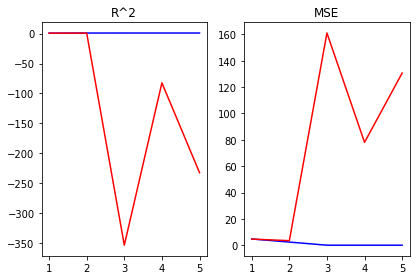

In [25]:
max_degrees = 5
degrees_range = np.arange(1, max_degrees + 1)

eval_metrics_dict = linear_regression(max_degrees)
plot_eval_metrics(degrees_range, eval_metrics_dict)